# py4DSTEM phase reconstruction of gold nanoparticle on carbon

Sam Welborn et al. "Streaming Large-Scale Microscopy Data to a Supercomputing Facility"

Stephanie Ribet, Georgios Varnavides, Colin Ophus

June 2023

In [1]:
import numpy as np
import stempy.io as stio
import ncempy
import py4DSTEM
print(py4DSTEM.__version__)


0.14.3


### load data

In [2]:
path_to_data = '/pscratch/sd/s/swelborn/streaming-paper/counted_data/FOURD_230815_0547_01432_00516.h5'
path_to_dm4 = '/pscratch/sd/s/swelborn/streaming-paper/counted_data/scan516.dm4'
sp = stio.SparseArray.from_hdf5(path_to_data)

sp = sp[:, :-1, :, :] # remove the fly back column

In [3]:
bin_factor = 16
dc = py4DSTEM.DataCube(
    sp.bin_frames(bin_factor).to_dense()
)

In [4]:
im =  ncempy.io.read(path_to_dm4)
# im =  ncempy.io.read('scan575.dm4')

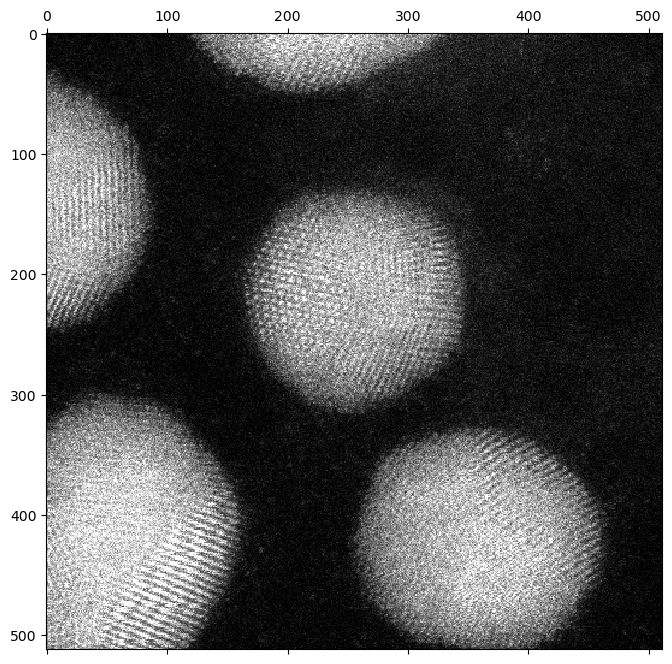

In [5]:
py4DSTEM.show(im['data'])

### calibrate

In [6]:
#Is this the right nanoparticle?
dc_cropped = dc.copy().crop_R((100,350,125,375))

In [7]:
dc_cropped.get_dp_mean()

VirtualDiffraction( A 2-dimensional array of shape (36, 36) called 'dp_mean',
                    with dimensions:

                        dim0 = [0,1,2,...] pixels
                        dim1 = [0,1,2,...] pixels
)

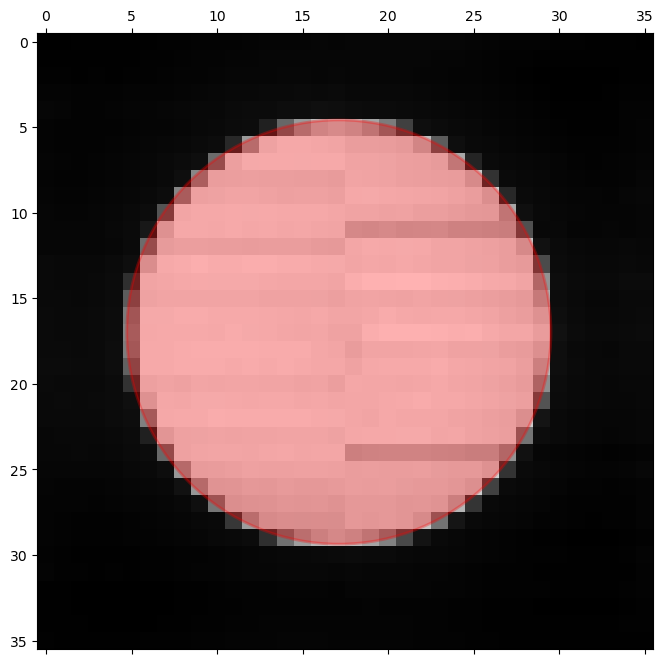

In [8]:
probe_radius_pixels, qx0, qy0 = dc_cropped.get_probe_size(
    plot = True
)

In [9]:
dc_cropped.calibration.set_R_pixel_size(im['pixelSize'][0]* 10)
dc_cropped.calibration.set_R_pixel_units('A')
dc_cropped.calibration.set_Q_pixel_size(17.1 / probe_radius_pixels)
dc_cropped.calibration.set_Q_pixel_units('mrad')

In [10]:
dc_cropped.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:      1.379594468869991
             R_pixel_size:      0.3615877032279968
             Q_pixel_units:     mrad
             R_pixel_units:     A
             probe_semiangle:   12.394946765774149
             qx0_mean:          16.96826903995309
             qy0_mean:          17.11479958972091
)

### dpc

/global/homes/s/swelborn/miniforge3/envs/mandm_paper/lib/python3.11/site-packages/py4DSTEM/process/phase/iterative_base_class.py:590: UserWarning: Best fit rotation forced to 256 degrees.
  warnings.warn(


No need to transpose diffraction intensities.


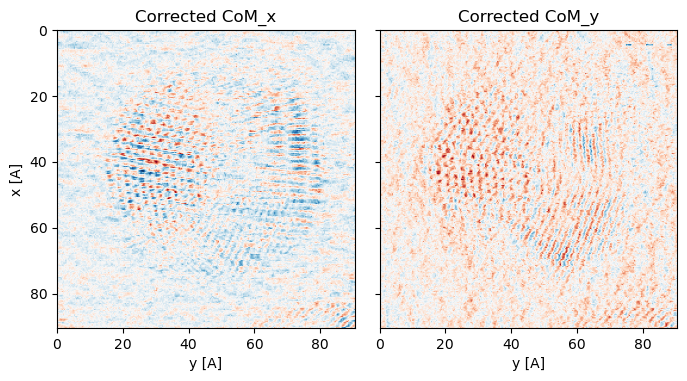

In [11]:
dpc = py4DSTEM.process.phase.DPCReconstruction(
    energy = 300e3,
    datacube = dc_cropped
).preprocess(
    force_com_rotation = 256
)

Reconstructing phase:  41%|████      | 26/64 [00:00<00:00, 81.40 iter/s]

Iteration 7, step reduced to 0.25
Iteration 8, step reduced to 0.125
Iteration 9, step reduced to 0.0625
Iteration 10, step reduced to 0.03125
Iteration 11, step reduced to 0.015625
Iteration 12, step reduced to 0.0078125
Iteration 13, step reduced to 0.00390625
Iteration 14, step reduced to 0.001953125
Iteration 15, step reduced to 0.0009765625
Iteration 16, step reduced to 0.00048828125
Iteration 17, step reduced to 0.000244140625
Iteration 18, step reduced to 0.0001220703125
Iteration 19, step reduced to 6.103515625e-05
Iteration 20, step reduced to 3.0517578125e-05
Iteration 21, step reduced to 1.52587890625e-05
Iteration 22, step reduced to 7.62939453125e-06
Iteration 23, step reduced to 3.814697265625e-06
Iteration 24, step reduced to 1.9073486328125e-06
Iteration 25, step reduced to 9.5367431640625e-07



/global/homes/s/swelborn/miniforge3/envs/mandm_paper/lib/python3.11/site-packages/py4DSTEM/process/phase/iterative_dpc.py:810: UserWarning: Step-size has decreased below stopping criterion 1e-06.
  warnings.warn(


DPCReconstruction( A Node called 'dpc_reconstruction', containing the following top-level objects in its tree:

)

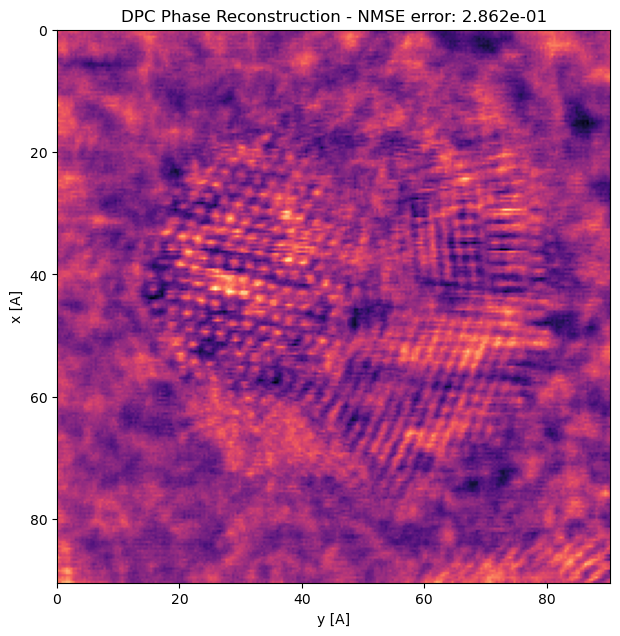

In [12]:
dpc.reconstruct(
    q_highpass = 0.03, 
    reset = True
).visualize()

### parallax

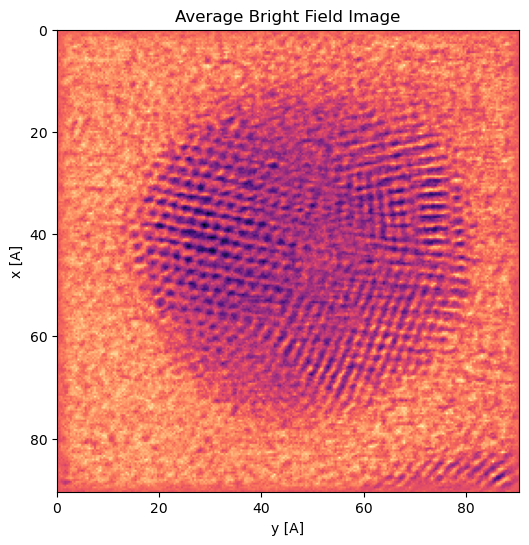

In [13]:
parallax = py4DSTEM.process.phase.ParallaxReconstruction(
    datacube = dc_cropped, 
    energy = 300e3,
    device = "cpu",
    object_padding_px=(16,16)
).preprocess(
    threshold_intensity=0.6,
    edge_blend = 8,
    defocus_guess=50,
    rotation_guess=256
)


Alignment at bin 4: 100%|██████████| 38/38 [00:00<00:00, 125.51 image subsets/s]


ParallaxReconstruction( A Node called 'parallax_reconstruction', containing the following top-level objects in its tree:

)

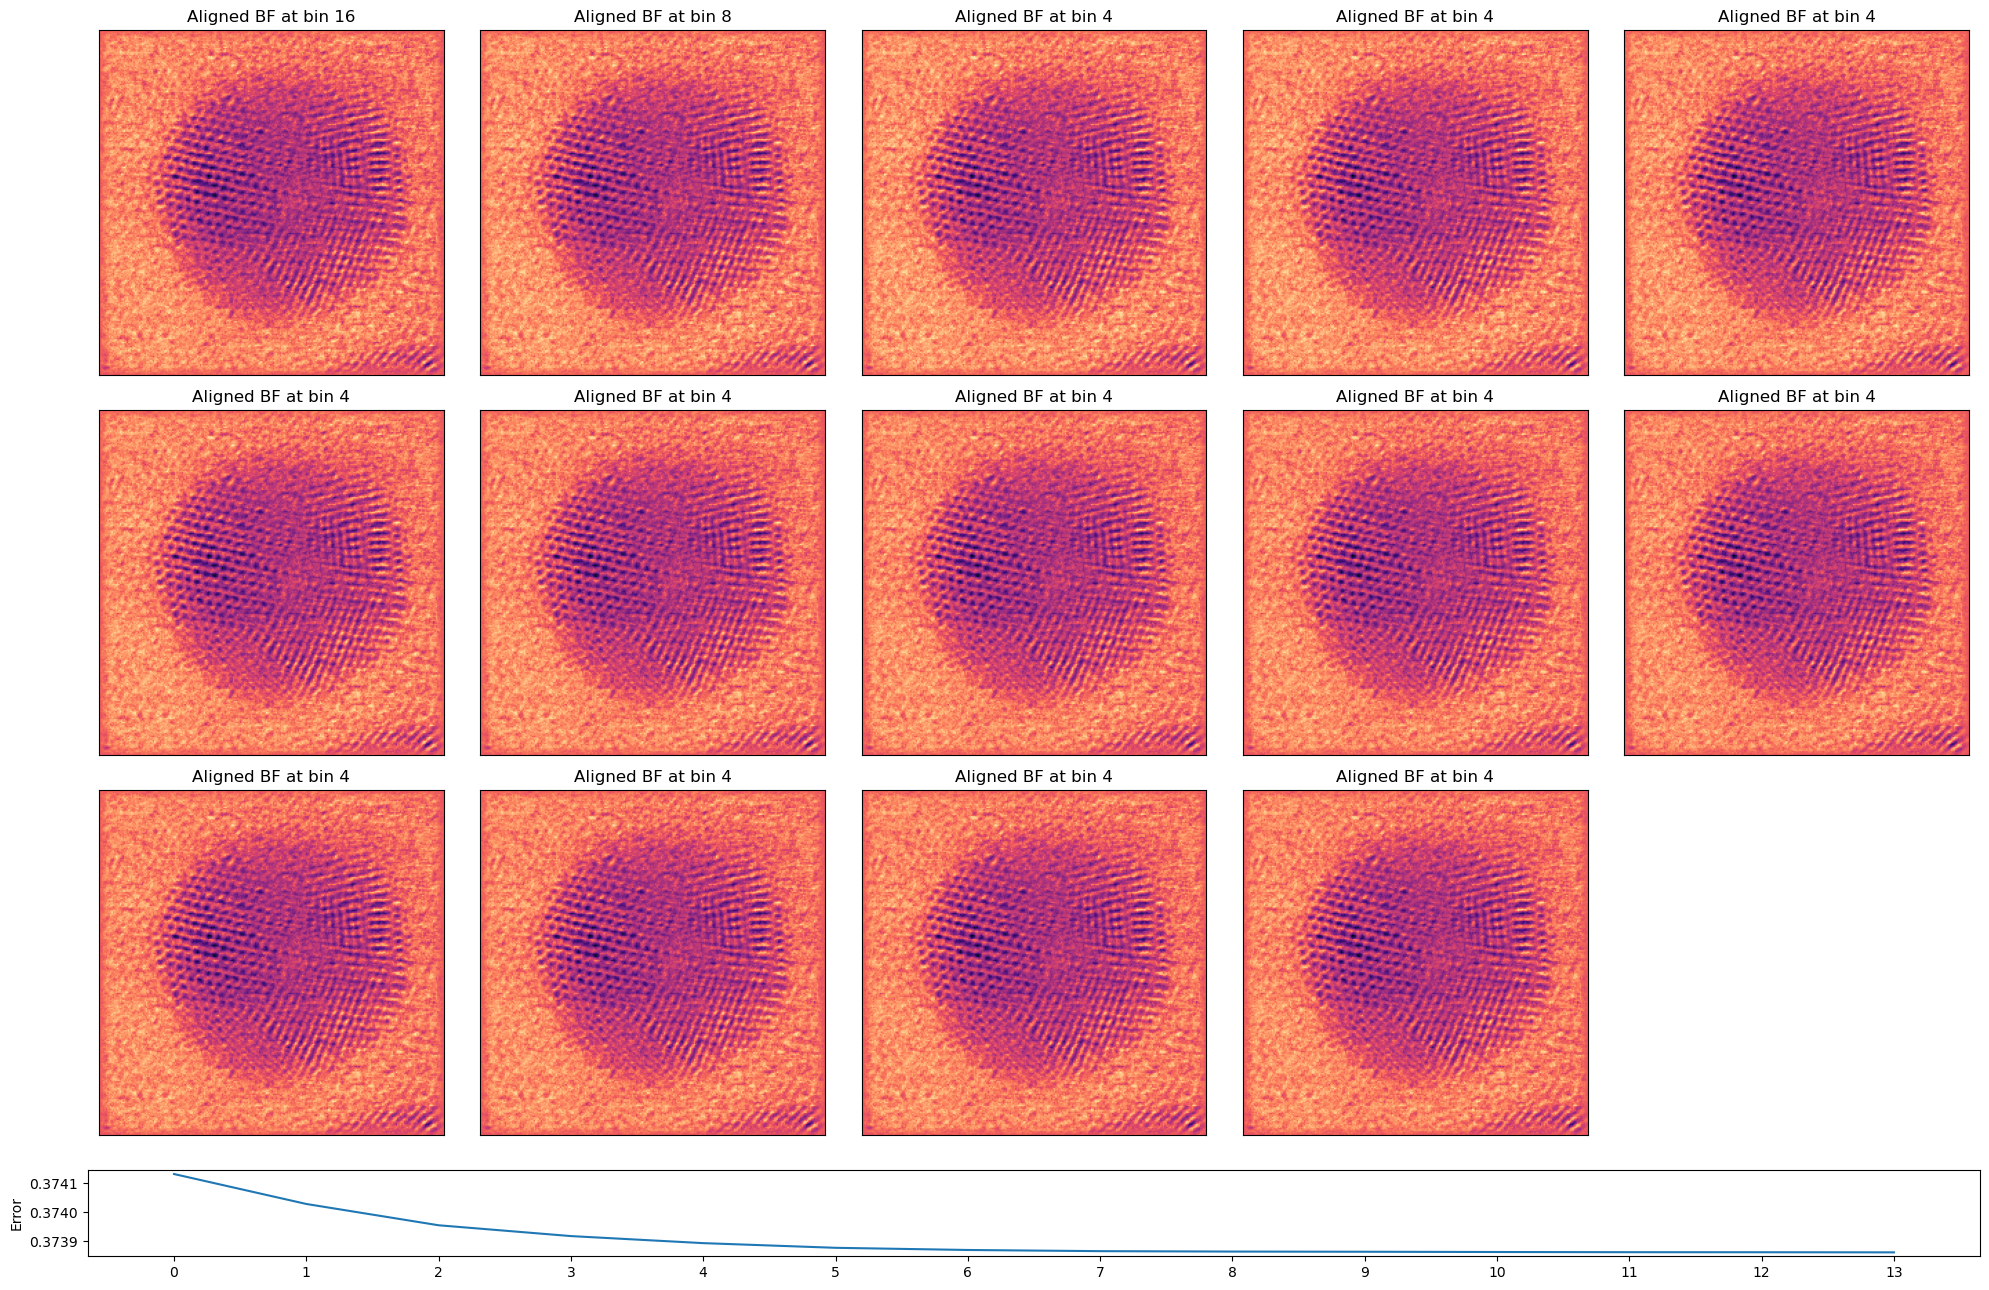

In [14]:
parallax.reconstruct(
    reset = True,
    min_alignment_bin = 4,
    max_iter_at_min_bin = 12,
    # regularize_shifts=True,
    # regularizer_matrix_size=(2,2),
    running_average = False
)

In [15]:
parallax.aberration_fit()

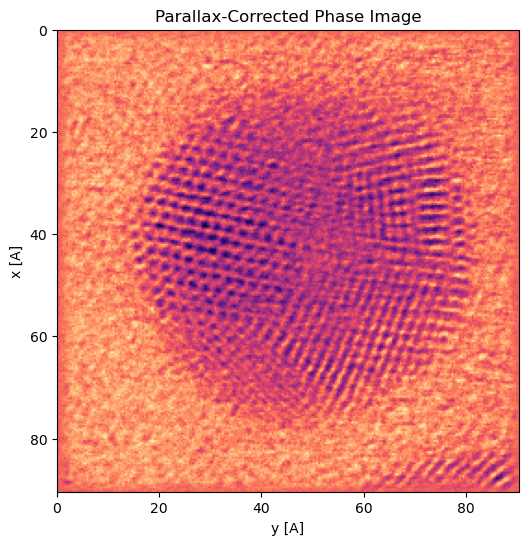

In [16]:
#### The contrast is backwards here. Make sure to update the plots if it looks like this. 
parallax.aberration_correct()

### ptycho

/global/homes/s/swelborn/miniforge3/envs/mandm_paper/lib/python3.11/site-packages/py4DSTEM/process/phase/iterative_base_class.py:590: UserWarning: Best fit rotation forced to 256 degrees.
  warnings.warn(
/global/homes/s/swelborn/miniforge3/envs/mandm_paper/lib/python3.11/site-packages/py4DSTEM/process/phase/iterative_base_class.py:604: UserWarning: Transpose of intensities forced to False.
  warnings.warn(


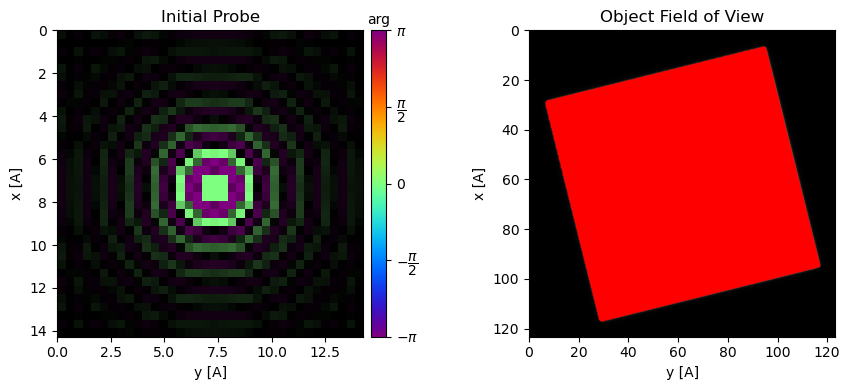

In [17]:
ptycho = py4DSTEM.process.phase.SingleslicePtychographicReconstruction(
    energy = 300e3,
    datacube = dc_cropped,
    semiangle_cutoff=17.1,
    defocus = 0, # -parallax.aberration_C1,
    device = "cpu",
    # object_type="potential"
).preprocess(
    force_com_transpose = False,
    force_com_rotation = 256, 
    plot_center_of_mass=False,
    fit_function = "constant"
)

In [18]:
ptycho = ptycho.reconstruct(
    reset=True,
    max_iter=1,
    step_size=0.1,
    max_batch_size = ptycho._num_diffraction_patterns//2,
    q_lowpass=1.75,
  
).visualize()

Performing 1 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1 and step _size: 0.1, in batches of max 31250 measurements.


Reconstructing object and probe:   0%|          | 0/1 [00:00<?, ? iter/s]

In [ ]:
p = parallax._object_padding_px[0]//2

In [ ]:
py4DSTEM.show(
    [
        -parallax.recon_phase_corrected[p:-p, p:-p], 
        np.angle(ptycho.object_cropped)
    ],
    cmap = "magma",
    title =  ["parallax","ptycho"],
    vmin = 0.2,
    vmax = 0.98
)